# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

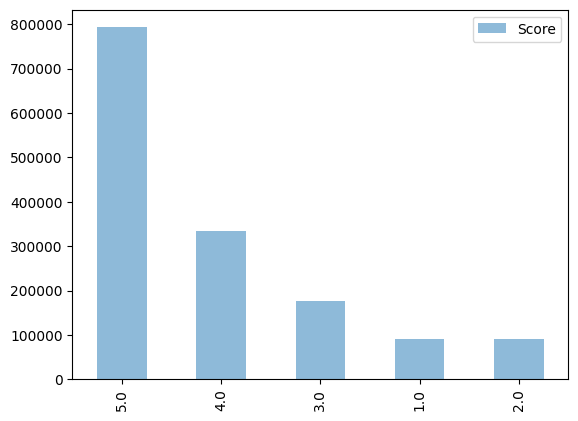


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [79]:
# Print all details of the training set for certain rows
print(trainingSet.iloc[1100:1120].to_string())
# print percentage of each score
print(trainingSet['Score'].value_counts(normalize=True))

           Id   ProductId          UserId  HelpfulnessNumerator  HelpfulnessDenominator        Time                                                             Summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Experiment with Relationships Between Existing Features

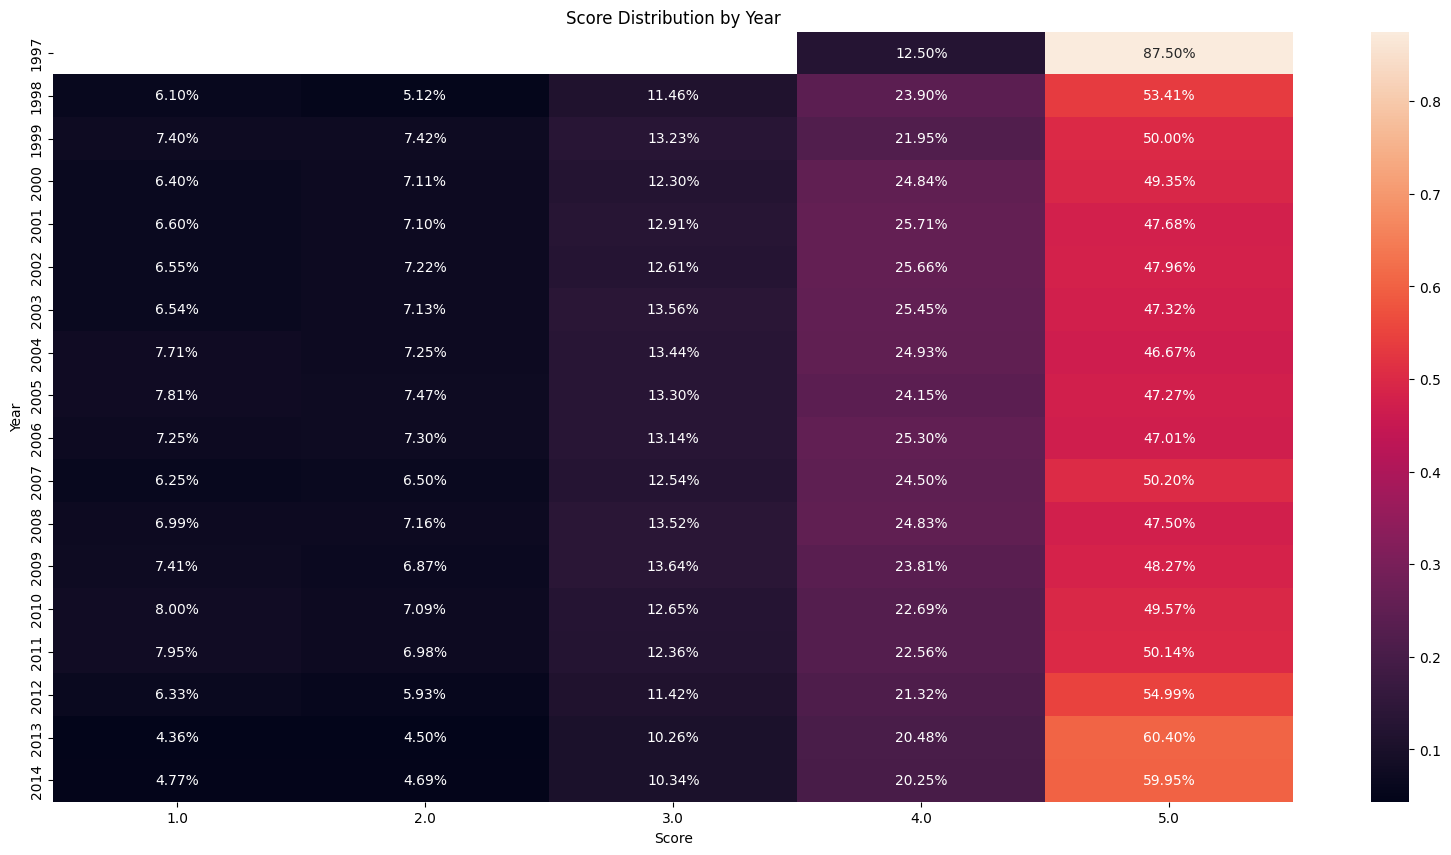

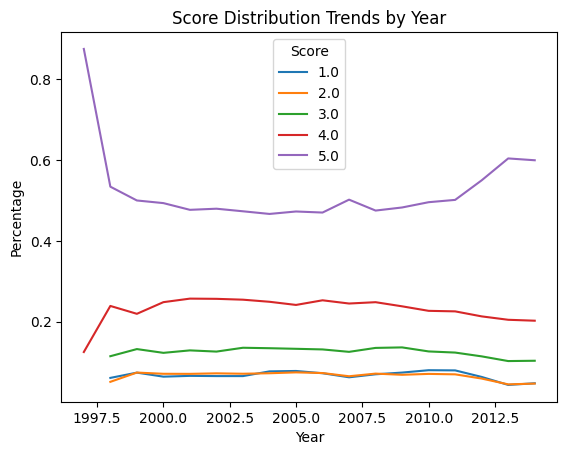

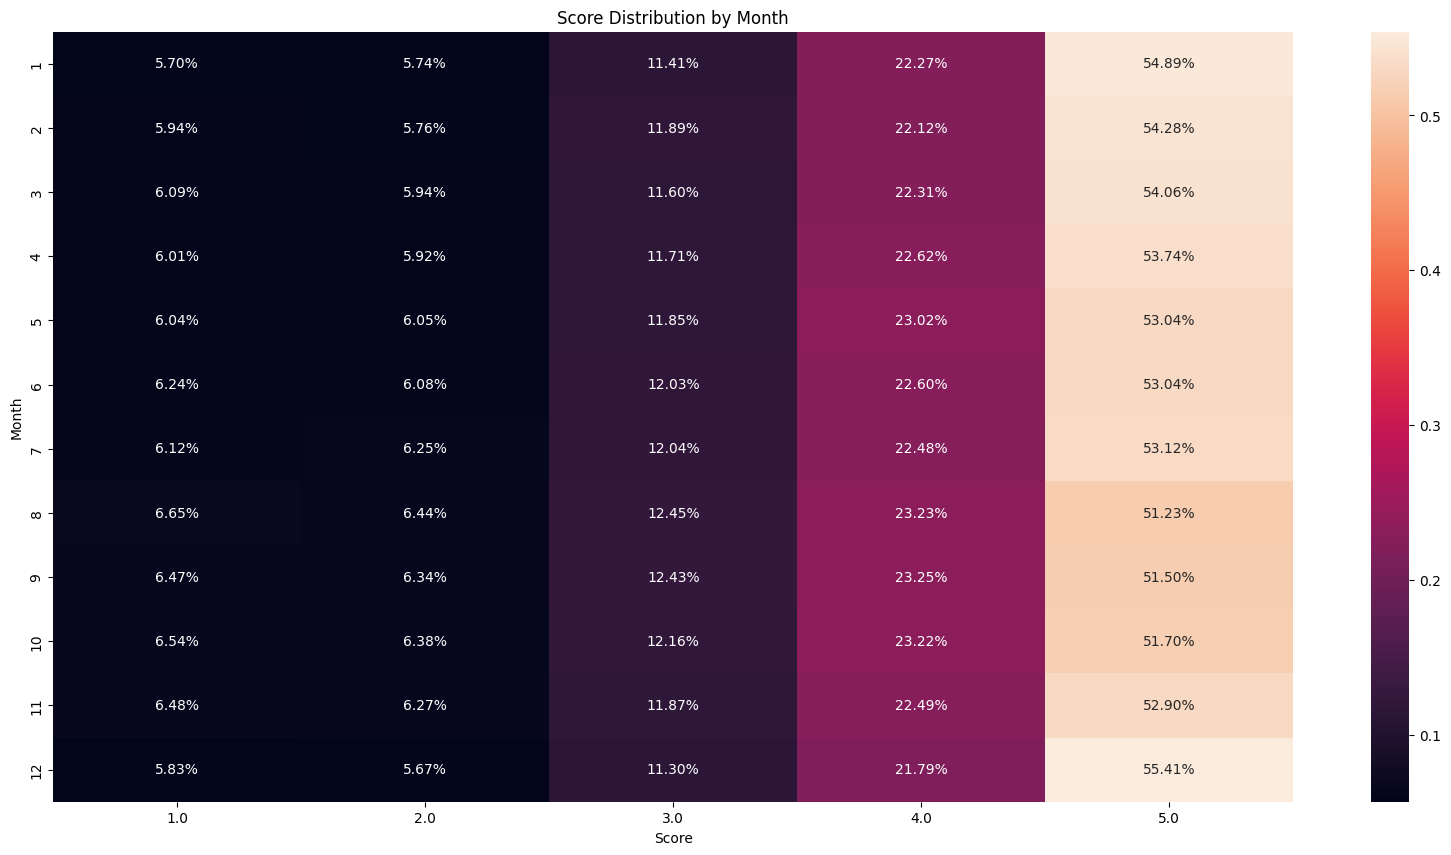

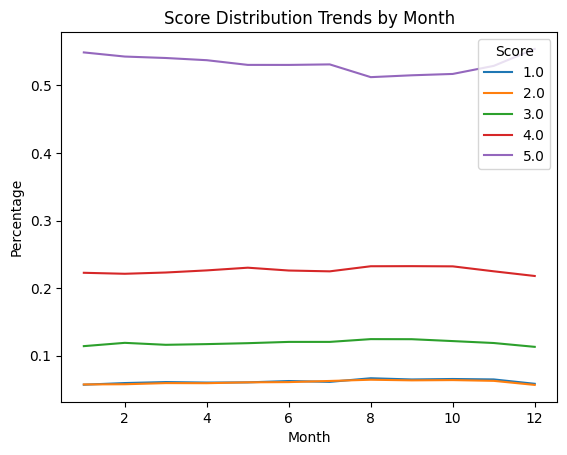

In [173]:

def process_timestamp(df, time_col='Time'):
    df['Year'] = pd.to_datetime(df[time_col], unit='s', errors='coerce').dt.year
    df['Month'] = pd.to_datetime(df[time_col], unit='s', errors='coerce').dt.month

def plot_heatmap(df, time_col, score_col, figsize=(20, 10), normalize=True):
    data = df.groupby([time_col, score_col]).size().unstack()
    if normalize:
        data = data.apply(lambda x: x / x.sum(), axis=1)
    plt.figure(figsize=figsize)
    sns.heatmap(data, annot=True, fmt='.2%' if normalize else 'd')
    plt.title(f'{score_col} Distribution by {time_col}')
    plt.show()

def plot_line_chart(df, time_col, score_col, normalize=True):
    data = df.groupby([time_col, score_col]).size().unstack()
    if normalize:
        data = data.apply(lambda x: x / x.sum(), axis=1)
    data.plot()
    plt.title(f'{score_col} Distribution Trends by {time_col}')
    plt.ylabel('Percentage' if normalize else 'Count')
    plt.xlabel(time_col)
    plt.show()

def run__time_score_relationship_analysis(df, time_col='Time', score_col='Score'):
    process_timestamp(df, time_col=time_col)
    plot_heatmap(df, time_col='Year', score_col=score_col)
    plot_line_chart(df, time_col='Year', score_col=score_col)
    plot_heatmap(df, time_col='Month', score_col=score_col)
    plot_line_chart(df, time_col='Month', score_col=score_col)

run__time_score_relationship_analysis(trainingSet)

In [174]:
# Main function to run all text analysis steps
def analyze_summary_data(df, score_col='Score', summary_col='Summary', text_col='Text', sample_size=10000):
    # Helper functions
    def preprocess_data(df, score_col, sample_size):
        return df.dropna(subset=[score_col]).iloc[:sample_size].copy()

    def get_top_words(df, score_col, summary_col, stop_words):
        word_clouds = {score: Counter() for score in range(1, 6)}
        
        # Process rows to build word counts for each score
        def process_row_summary(row):
            if isinstance(row[summary_col], str):
                words = (word for word in row[summary_col].lower().split() if word not in stop_words)
                word_clouds[row[score_col]].update(words)
        
        df.apply(process_row_summary, axis=1)
        return {score: [word for word, _ in counter.most_common(10)] for score, counter in word_clouds.items()}

    def add_match_count_columns(df, text_col, top_words, stop_words):
        # Adds match count columns for each score's top words
        def process_row_match_count(row):
            if isinstance(row[text_col], str):
                words = set(word for word in row[text_col].lower().split() if word not in stop_words)
                for score in range(1, 6):
                    row[f'top_10_match_count_score_{score}'] = sum(word in top_words[score] for word in words)
            return row

        return df.apply(process_row_match_count, axis=1)

    # Parameters
    stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'if', 'then', 'else', 
                      'for', 'of', 'with', 'without', 'in', 'out', 'on', 'off', 
                      'over', 'under', 'movie', 'this', 'not', 'is', 'i', 'to', 
                      'it', 'what', 'as', 'at', 'so', 'we', 'by', 'that', 'are', '-'])
    
    # Step-by-step execution
    df = preprocess_data(df, score_col, sample_size)
    top_words = get_top_words(df, score_col, summary_col, stop_words)
    df = add_match_count_columns(df, text_col, top_words, stop_words)
    
    # Display top words for each score
    for score, words in top_words.items():
        print(f"Top 10 words for score {score}: {words}")
    
    return df

# Delete the columns first if they already exist for top_10_match_count_score_{score}
for col in trainingSet.columns:
    if 'top_10_match_count_score_' in col:
        del trainingSet[col]
# Run analysis
temp_trainingSet_Summary = analyze_summary_data(trainingSet, score_col='Score', summary_col='Summary', text_col='Text')

# Verify by printing a sample of rows
print(temp_trainingSet_Summary.iloc[10:20].to_string())

KeyboardInterrupt: 

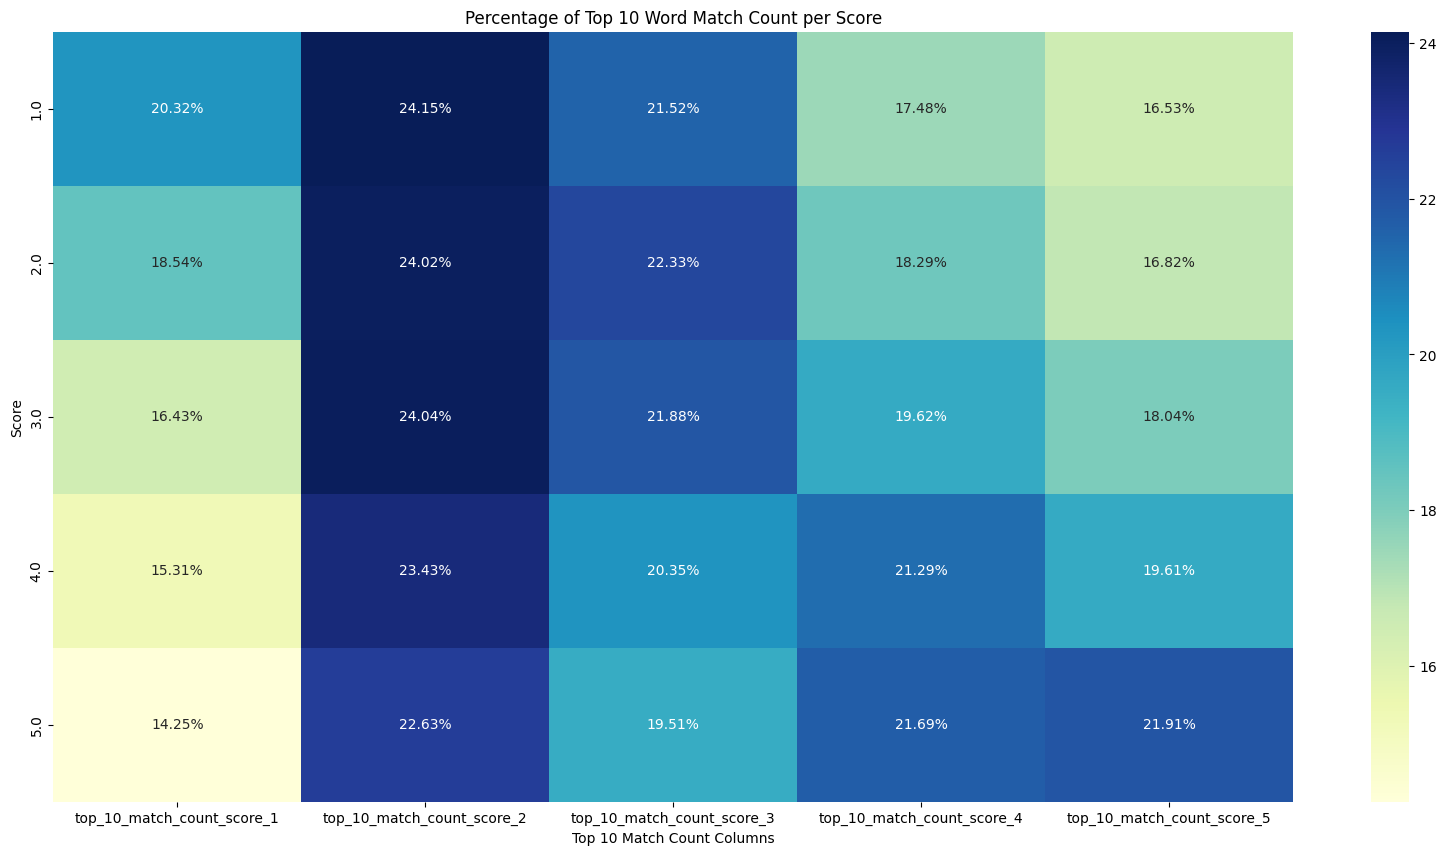

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_score_relationship_percentage(df, score_col='Score'):
    """
    Plots a heatmap showing the percentage relationship between scores and the average match count 
    for top words associated with each score.
    """
    # Select columns related to top 10 word match counts
    match_count_cols = [col for col in df.columns if col.startswith('top_10_match_count_score_')]
    
    # Calculate mean match count for each score and normalize by row to get percentages
    mean_counts = df.groupby(score_col)[match_count_cols].mean()
    percentage_counts = mean_counts.div(mean_counts.sum(axis=1), axis=0) * 100

    # Format the annotations to include '%' sign
    annot = percentage_counts.applymap(lambda x: f"{x:.2f}%")

    # Plot heatmap with percentage format
    plt.figure(figsize=(20, 10))
    sns.heatmap(percentage_counts, annot=annot, fmt='', cmap='YlGnBu')
    plt.title('Percentage of Top 10 Word Match Count per Score')
    plt.xlabel('Top 10 Match Count Columns')
    plt.ylabel('Score')
    plt.show()

# Run the function to visualize the percentage relationship
plot_score_relationship_percentage(temp_trainingSet_Summary, score_col='Score')

In [43]:
import pandas as pd
from collections import Counter
from itertools import tee, islice

# Main function to run all text analysis steps with single words and bigrams
def analyze_text_data(df, score_col='Score', text_col='Text', sample_size=50000):
    # Helper functions
    def preprocess_data(df, score_col, sample_size):
        return df.dropna(subset=[score_col]).iloc[:sample_size].copy()

    def generate_bigrams(words):
        # Generate bigrams as tuples
        first, second = tee(words)
        next(second, None)
        return zip(first, second)
    
    def get_top_words(df, score_col, text_col, stop_words):
        word_clouds = {score: Counter() for score in range(1, 6)}
        
        # Process rows to build word counts for each score
        def process_row_text(row):
            if isinstance(row[text_col], str):
                words = [word for word in row[text_col].lower().split() if word not in stop_words]
                bigrams = list(generate_bigrams(words))
                word_clouds[row[score_col]].update(words + bigrams)
        
        df.apply(process_row_text, axis=1)
        # Collect top 10 single words and bigrams for each score
        return {
            score: [word for word, _ in counter.most_common(20)] 
            for score, counter in word_clouds.items()
        }

    def add_match_count_columns(df, text_col, top_words, stop_words):
        # Adds match count columns for each score's top words and bigrams
        def process_row_match_count(row):
            if isinstance(row[text_col], str):
                words = [word for word in row[text_col].lower().split() if word not in stop_words]
                bigrams = list(generate_bigrams(words))
                words_and_bigrams = set(words + bigrams)  # Combine single words and bigrams
                
                for score in range(1, 6):
                    row[f'top_10_match_count_score_{score}'] = sum(
                        word in top_words[score] for word in words_and_bigrams
                    )
            return row

        return df.apply(process_row_match_count, axis=1)

    # Define stop words
    stop_words = set([
        'the', 'a', 'an', 'and', 'or', 'but', 'if', 'then', 'else', 'for', 'of', 'with', 'without', 'in', 'out',
        'on', 'off', 'over', 'under', 'movie', 'this', 'not', 'is', 'i', 'to', 'it', 'what', 'as', 'at', 'so',
        'we', 'by', 'that', 'are', '-', 'was', 'you', 'his', 'he', 'they', 'who', 'all', 'have', 'be', 'like',
        'from', 'film', 'one', 'just', 'about', 'no', 'would', "it's", 'my', 'even', 'there', 'has', 'when', 'only',
        'more', 'some', 'her', 'very', 'will', 'their', 'do', 'which', 'me', 'were', 'can', 'could', 'should',
        'would', 'might', 'must', 'may', 'had', 'having', 'here', 'where', 'why', 'whoever', 'whatever', 'whenever',
        'however', 'such', 'more', 'less', 'than', 'too', 'both', 'each', 'either', 'neither', 'any', 'every', 'those',
        'these', 'what', 'this', 'that', 'there', 'then', 'so', 'now', 'up', 'down', 'back', 'out', 'in', 'about', 
        'over', 'after', 'before', 'during', 'until', 'since', 'while', 'like', 'off', 'along', 'against', 
        'through', 'during', 'among', 'at', 'by', 'for', 'into', 'to', 'with', 'of', 'on', 'from', 'as', 
        'like', 'then', 'but', 'or', 'and', 'if', 'so', 'not', 'yes', 'no', 'why', 'what', 'when', 'where', 
        'how', 'do', 'does', 'did', 'is', 'are', 'was', 'were', 'be', 'been', 'having', 'could', 'should', 
        'might', 'must', 'want', 'wanting', 'need', 'needing', 'know', 'knowing', 'like', 'such', 'more', 
        'less', 'same', 'different', 'because', 'make', 'see', 'good', 'really', 'much', 'get', 'first', 'other', 'most', 'also', 'its', 'time', 'many', 'she', 'it.', 'dvd',
        'story', 'two', 'think', 'being', 'them', 'your', 'people', 'him', 'watch', 'movie.', 'made',
        'way', 'movies', 'movie,', 'films', 'character', 'characters', 'something', 'seen', 'still', 'ever', 'little'
    ])

    # Step-by-step execution
    df = preprocess_data(df, score_col, sample_size)
    top_words = get_top_words(df, score_col, text_col, stop_words)
    df = add_match_count_columns(df, text_col, top_words, stop_words)
    
    # Display top words and bigrams for each score
    for score, words in top_words.items():
        print(f"Top 10 words/bigrams for score {score}: {words}")
    
    return df

# Delete existing columns for match counts if they exist
for col in trainingSet.columns:
    if col.startswith('top_10_match_count_score_'):
        del trainingSet[col]

# Run analysis
temp_trainingSet_Text = analyze_text_data(trainingSet, score_col='Score', text_col='Text')

# Verify by printing a sample of rows
print(temp_trainingSet_Text.iloc[10:20].to_string())


Top 10 words/bigrams for score 1: ["don't", 'bad', 'never', "didn't", 'better', 'nothing', 'watching', "i'm", 'great', 'love', 'going', 'waste', 'go', 'say', 'acting', "can't", "doesn't", 'worst', 'plot', 'actually']
Top 10 words/bigrams for score 2: ["don't", 'bad', 'better', 'never', 'great', "didn't", 'going', "i'm", 'plot', "doesn't", 'nothing', 'watching', 'scenes', 'well', 'pretty', 'few', 'acting', 'another', 'love', 'film.']
Top 10 words/bigrams for score 3: ['great', "don't", 'better', 'well', 'never', 'bad', 'new', "didn't", 'pretty', 'best', 'love', 'plot', 'bit', 'lot', "doesn't", 'show', 'few', 'seems', 'film.', 'scenes']
Top 10 words/bigrams for score 4: ['great', 'well', "don't", 'best', 'love', 'new', 'never', 'show', 'better', 'lot', 'find', 'makes', 'series', 'quite', 'go', 'few', 'bit', 'scenes', 'pretty', 'man']
Top 10 words/bigrams for score 5: ['great', 'love', 'best', 'well', 'show', 'series', 'never', "don't", 'new', 'season', 'life', 'watching', '&', 'years', '

NameError: name 'temp_trainingSet' is not defined

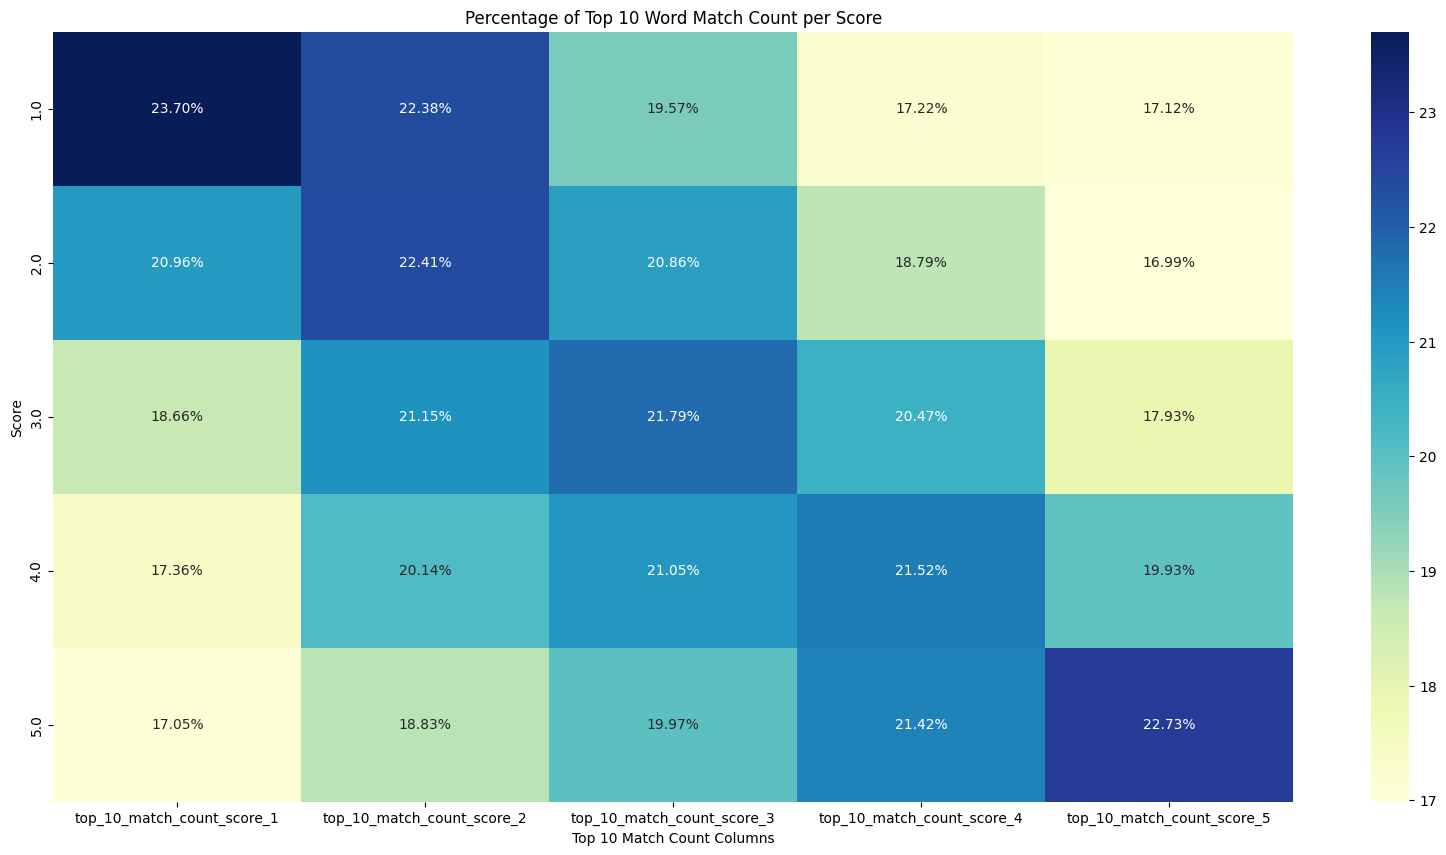

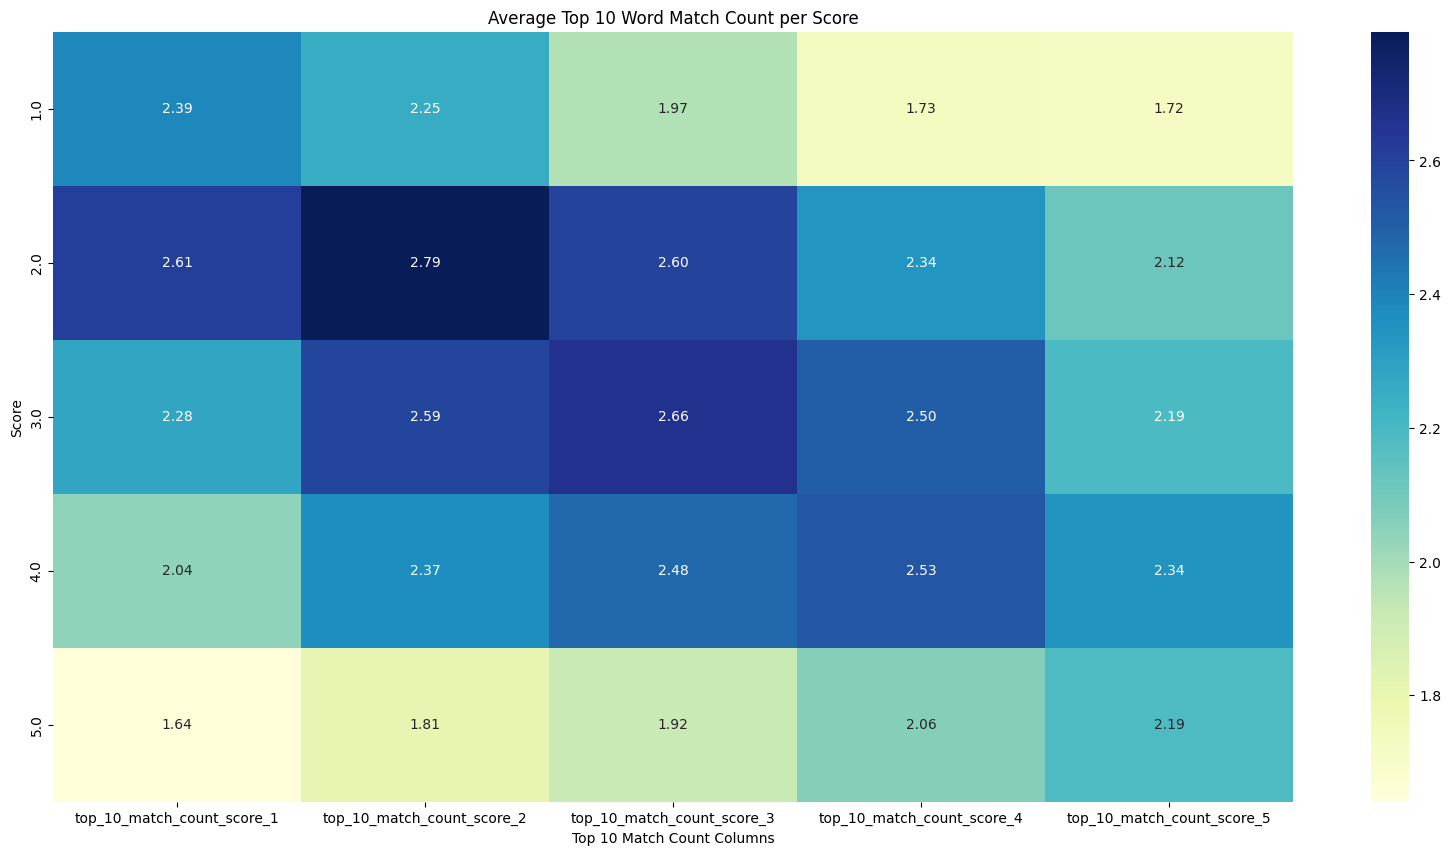

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_score_relationship_percentage(df, score_col='Score'):
    """
    Plots a heatmap showing the percentage relationship between scores and the average match count 
    for top words associated with each score.
    """
    # Select columns related to top 10 word match counts
    match_count_cols = [col for col in df.columns if col.startswith('top_10_match_count_score_')]
    
    # Calculate mean match count for each score and normalize by row to get percentages
    mean_counts = df.groupby(score_col)[match_count_cols].mean()
    percentage_counts = mean_counts.div(mean_counts.sum(axis=1), axis=0) * 100

    # Format the annotations to include '%' sign
    annot = percentage_counts.applymap(lambda x: f"{x:.2f}%")

    # Plot heatmap with percentage format
    plt.figure(figsize=(20, 10))
    sns.heatmap(percentage_counts, annot=annot, fmt='', cmap='YlGnBu')
    plt.title('Percentage of Top 10 Word Match Count per Score')
    plt.xlabel('Top 10 Match Count Columns')
    plt.ylabel('Score')
    plt.show()

def plot_score_relationship_average(df, score_col='Score'):
    """
    Plots a heatmap showing the average match count for top words associated with each score.
    """
    # Select columns related to top 10 word match counts
    match_count_cols = [col for col in df.columns if col.startswith('top_10_match_count_score_')]
    
    # Calculate the mean match count for each score
    mean_counts = df.groupby(score_col)[match_count_cols].mean()

    # Plot heatmap of average match counts
    plt.figure(figsize=(20, 10))
    sns.heatmap(mean_counts, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title('Average Top 10 Word Match Count per Score')
    plt.xlabel('Top 10 Match Count Columns')
    plt.ylabel('Score')
    plt.show()

# Run the function to visualize the percentage relationship
plot_score_relationship_percentage(temp_trainingSet_Text, score_col='Score')

# Run the function to visualize the average relationship
plot_score_relationship_average(temp_trainingSet_Text, score_col='Score')


# Adding Features

In [50]:
from nltk.tokenize import word_tokenize
from nltk.corpus import opinion_lexicon

import nltk
from tqdm import tqdm

nltk.download('opinion_lexicon')
nltk.download('punkt')

from joblib import Parallel, delayed
import multiprocessing

# Get positive and negative word sets
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\opinion_lexicon.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
def add_missing_features(df, verbose=True):
    """Add only missing features to the dataframe efficiently"""
    if verbose:
        print("\nChecking for missing features...")
    
    features_to_add = {
        'basic': ['Helpfulness', 'text_length', 'summary_length', 'word_count', 'summary_word_count'],
        'score_matches': [f'score_{i}_word_matches' for i in range(1, 6)],
        'score_ratios': [f'score_{i}_word_ratio' for i in range(1, 6)],
	'sentiment': ['text_pos_words', 'text_neg_words', 'summary_pos_words', 'summary_neg_words', 'text_pos_ratio', 'text_neg_ratio', 'summary_pos_ratio', 'summary_neg_ratio']
    }
    
    # Check which features are missing
    missing_basic = [f for f in features_to_add['basic'] if f not in df.columns]
    missing_matches = [f for f in features_to_add['score_matches'] if f not in df.columns]
    missing_ratios = [f for f in features_to_add['score_ratios'] if f not in df.columns]
    missing_sentiment = [f for f in features_to_add['sentiment'] if f not in df.columns]
    
    if verbose and (missing_basic or missing_matches or missing_ratios):
        print("Missing features found:")
        if missing_basic: print(f"Basic features: {missing_basic}")
        if missing_matches: print(f"Score match features: {missing_matches}")
        if missing_ratios: print(f"Score ratio features: {missing_ratios}")
        if missing_sentiment: print(f"Sentiment features: {missing_sentiment}")
    elif verbose:
        print("All features already present!")
        return df
    
    # Only add what's missing
    if 'Helpfulness' in missing_basic:
        if verbose: print("\nCalculating Helpfulness...")
        df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
        df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    if any(f in missing_basic for f in ['text_length', 'summary_length', 'word_count', 'summary_word_count']):
        if verbose: print("Adding text length features...")
        if 'text_length' in missing_basic:
            df['text_length'] = df['Text'].fillna('').str.len()
        if 'summary_length' in missing_basic:
            df['summary_length'] = df['Summary'].fillna('').str.len()
        if 'word_count' in missing_basic:
            df['word_count'] = df['Text'].fillna('').str.split().str.len()
        if 'summary_word_count' in missing_basic:
            df['summary_word_count'] = df['Summary'].fillna('').str.split().str.len()
    
    if missing_matches or missing_ratios:
        if verbose: print("Adding word matching features...")
        # Your existing score_words dictionary here
        score_words = {
            1: ["don't", 'bad', 'never', "didn't", 'better', 'nothing', 'watching', "i'm", 'great', 'love', 'going', 'waste', 'go', 'say', 'acting', "can't", "doesn't", 'worst', 'plot', 'actually'],
            2: ["don't", 'bad', 'better', 'never', 'great', "didn't", 'going', "i'm", 'plot', "doesn't", 'nothing', 'watching', 'scenes', 'well', 'pretty', 'few', 'acting', 'another', 'love', 'film.'],
            3: ['great', "don't", 'better', 'well', 'never', 'bad', 'new', "didn't", 'pretty', 'best', 'love', 'plot', 'bit', 'lot', "doesn't", 'show', 'few', 'seems', 'film.', 'scenes'],
            4: ['great', 'well', "don't", 'best', 'love', 'new', 'never', 'show', 'better', 'lot', 'find', 'makes', 'series', 'quite', 'go', 'few', 'bit', 'scenes', 'pretty', 'man'],
            5: ['great', 'love', 'best', 'well', 'show', 'series', 'never', "don't", 'new', 'season', 'life', 'watching', '&', 'years', 'better', 'old', 'makes', 'set', 'always', 'go']
        }
        
        # Convert text to lowercase once for efficiency
        text_lower = df['Text'].fillna('').str.lower()
        summary_lower = df['Summary'].fillna('').str.lower()
        
        for score, words in score_words.items():
            if f'score_{score}_word_matches' in missing_matches:
                # Vectorized matching for text and summary
                df[f'score_{score}_word_matches'] = text_lower.apply(lambda x: sum(x.count(word) for word in words)) + summary_lower.apply(lambda x: 2 * sum(x.count(word) for word in words))
            if f'score_{score}_word_ratio' in missing_ratios:
                df[f'score_{score}_word_ratio'] = df[f'score_{score}_word_matches'] / df['word_count'].replace(0, 1)

    if missing_sentiment:
        if verbose: print("Adding sentiment features...")


        num_cores = multiprocessing.cpu_count()

        def get_sentiment_counts(text):
            if pd.isna(text):
                return {'pos': 0, 'neg': 0}
            words = word_tokenize(str(text).lower())
            pos_count = sum(1 for word in words if word in positive_words)
            neg_count = sum(1 for word in words if word in negative_words)
            return {'pos': pos_count, 'neg': neg_count}

        print("Moving to text sentiment features...")
        if any(f.startswith('text_') for f in missing_sentiment):
            text_sentiments = Parallel(n_jobs=num_cores)(delayed(get_sentiment_counts)(text) for text in df['Text'])
            text_sentiments_df = pd.DataFrame(text_sentiments)
            df['text_pos_words'] = text_sentiments_df.apply(lambda x: x['pos'])
            df['text_neg_words'] = text_sentiments_df.apply(lambda x: x['neg'])
            df['text_pos_ratio'] = df['text_pos_words'] / df['word_count'].replace(0, 1)
            df['text_neg_ratio'] = df['text_neg_words'] / df['word_count'].replace(0, 1)

        print("Moving to summary sentiment features...")
        if any(f.startswith('summary_') for f in missing_sentiment):
            summary_sentiments = Parallel(n_jobs=num_cores)(delayed(get_sentiment_counts)(summary) for summary in df['Summary'])
            summary_sentiments_df = pd.DataFrame(text_sentiments)
            df['summary_pos_words'] = summary_sentiments_df.apply(lambda x: x['pos'])
            df['summary_neg_words'] = summary_sentiments_df.apply(lambda x: x['neg'])
            df['summary_pos_ratio'] = df['summary_pos_words'] / df['summary_word_count'].replace(0, 1)
            df['summary_neg_ratio'] = df['summary_neg_words'] / df['summary_word_count'].replace(0, 1)

    return df

# Use the function
if exists('./data/X_train.pkl'):
    X_train = pd.read_pickle("./data/X_train.pkl")
    X_submission = pd.read_pickle("./data/X_submission.pkl")
else:
    # Initial processing
    print("Processing training set...")
    train = add_missing_features(trainingSet)
    
    print("\nCreating submission set...")
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    X_train = train[train['Score'].notnull()]
    
    print("\nSaving files...")
    X_train.to_pickle("./data/X_train.pkl")
    X_submission.to_pickle("./data/X_submission.pkl")

# Check and add any missing features
print("\nChecking training set...")
X_train = add_missing_features(X_train)
print("\nChecking submission set...")
X_submission = add_missing_features(X_submission)

# Save updated files
print("\nSaving updated files...")
X_train.to_pickle("./data/X_train.pkl")
X_submission.to_pickle("./data/X_submission.pkl")



Checking training set...

Checking for missing features...
All features already present!

Checking submission set...

Checking for missing features...
All features already present!

Saving updated files...


# Sample + Split into training and testing set

In [74]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [75]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', "text_length", "summary_length", "word_count", "summary_word_count",
            'score_1_word_matches', 'score_1_word_ratio', 'score_2_word_matches', 'score_2_word_ratio', 'score_3_word_matches'
            , 'score_3_word_ratio', 'score_4_word_matches', 'score_4_word_ratio', 'score_5_word_matches', 'score_5_word_ratio']

X_train_select = X_train[features]
X_test_select = X_test[features]
# Convert to numpy arrays
X_train_select = X_train_select.to_numpy()
X_test_select = X_test_select.to_numpy()
X_submission_select = X_submission[features]

Y_train = Y_train.to_numpy() if hasattr(Y_train, 'to_numpy') else Y_train

# Model Creation

In [58]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=27).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

In [63]:
# Faster algorithm
X_train = X_train.select_dtypes(include=[float, int])
X_test = X_test.select_dtypes(include=[float, int])

# Initialize the model with BallTree or KDTree
model = KNeighborsClassifier(n_neighbors=27, algorithm='ball_tree')  # or algorithm='kd_tree'

# Train the model
model.fit(X_train, Y_train)

# Make predictions
Y_test_predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_test_predictions)
print("Accuracy on testing set =", accuracy)

Accuracy on testing set = 0.5181237477648275


# Model Evaluation

Accuracy on testing set =  0.5184711420384773


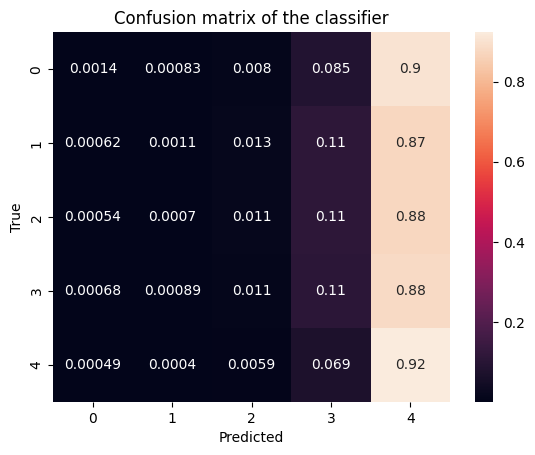

Mean Squared Error =  2.134503522416356


In [59]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()

# generate a squared means error analysis
mse = ((Y_test - Y_test_predictions) ** 2).mean()
print("Mean Squared Error = ", mse)

# Trying Out Results from Ensemble Bagging

In [92]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier

def stratified_bagging_with_weighted_voting(X, y, n_estimators=8, n_neighbors=27, algorithm='ball_tree'):
    """
    Trains a stratified bagging ensemble with custom weighted voting.
    
    Parameters:
    - X: Feature matrix
    - y: Target array
    - n_estimators: Number of estimators in the ensemble
    - n_neighbors: Number of neighbors for each KNN model
    - algorithm: Algorithm to use for KNN (e.g., 'ball_tree' for faster performance)
    
    Returns:
    - estimators: List of trained KNN estimators
    - class_weights: Dictionary of class weights based on inverse frequency
    """
    # Calculate class weights based on inverse class frequencies
    class_counts = Counter(y)
    total_samples = len(y)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Initialize list for models
    estimators = []
    for i in range(n_estimators):
        # Perform stratified sampling
        X_sample, y_sample = resample(X, y, stratify=y, n_samples=len(y) // n_estimators, random_state=i)
        
        # Initialize and train the KNN model
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
        knn.fit(X_sample, y_sample)
        estimators.append(knn)
    
    return estimators, class_weights

def predict_with_weighted_bagging(estimators, class_weights, X):
    """
    Predicts using a weighted voting system to account for class imbalance.
    
    Parameters:
    - estimators: List of trained estimators
    - class_weights: Dictionary of class weights
    - X: Feature matrix for predictions
    
    Returns:
    - predictions: Final predictions after weighted voting
    """
    # Collect predictions from each estimator
    all_predictions = np.array([est.predict(X) for est in estimators])
    
    # Apply weighted voting
    weighted_votes = []
    for preds in all_predictions.T:  # iterate over samples
        vote_counts = Counter(preds)
        
        # Apply class weights to each prediction count
        weighted_count = {cls: count * class_weights.get(cls, 1) for cls, count in vote_counts.items()}
        
        # Select the class with the highest weighted count
        weighted_votes.append(max(weighted_count, key=weighted_count.get))
    
    return np.array(weighted_votes)

Training stratified bagging model with custom weighted voting...
Predicting on test set...
Accuracy on test set: 0.5235904948617963


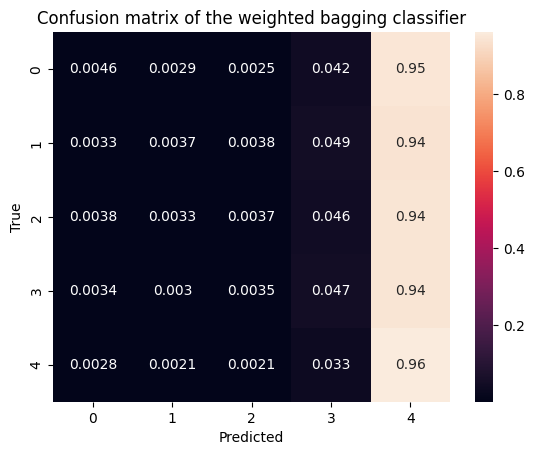

In [93]:
print("Training stratified bagging model with custom weighted voting...")
estimators, class_weights = stratified_bagging_with_weighted_voting(X_train_select, Y_train)

print("Predicting on test set...")
Y_test_predictions = predict_with_weighted_bagging(estimators, class_weights, X_test_select)

# Evaluate performance on test set
accuracy = accuracy_score(Y_test, Y_test_predictions)
print("Accuracy on test set:", accuracy)

# Optional: Confusion matrix for a detailed breakdown
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the weighted bagging classifier')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


In [94]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE) between actual and predicted values
def calculate_mse(y_true, y_pred):
    """
    Calculates the Mean Squared Error (MSE) between actual and predicted values.
    
    Parameters:
    - y_true: Array of actual target values
    - y_pred: Array of predicted target values
    
    Returns:
    - mse: The mean squared error
    - sum_squared_diff: Sum of all squared differences
    """
    # Compute MSE
    mse = mean_squared_error(y_true, y_pred)
    
    # Compute sum of squared differences
    sum_squared_diff = ((y_true - y_pred) ** 2).sum()
    
    return mse, sum_squared_diff

# Calculate MSE and sum of squared differences for test set predictions
mse, sum_squared_diff = calculate_mse(Y_test, Y_test_predictions)

print("Mean Squared Error (MSE):", mse)
print("Sum of all squared differences:", sum_squared_diff)


Mean Squared Error (MSE): 2.218532541956611
Sum of all squared differences: 823821.0


In [95]:
# create two more models for 9 and 10 n estimators, then run mean squared error analysis
print("Training stratified bagging model with custom weighted voting...")
estimators_9, class_weights_9 = stratified_bagging_with_weighted_voting(X_train_select, Y_train, n_estimators=9)

print("Predicting on test set...")
Y_test_predictions_9 = predict_with_weighted_bagging(estimators_9, class_weights_9, X_test_select)

# Evaluate performance on test set
accuracy_9 = accuracy_score(Y_test, Y_test_predictions_9)
print("Accuracy on test set with 9 estimators:", accuracy_9)

# Calculate MSE and sum of squared differences for test set predictions
mse_9, sum_squared_diff_9 = calculate_mse(Y_test, Y_test_predictions_9)

print("Mean Squared Error (MSE) with 9 estimators:", mse_9)
print("Sum of all squared differences with 9 estimators:", sum_squared_diff_9)

print("Training stratified bagging model with custom weighted voting...")
estimators_10, class_weights_10 = stratified_bagging_with_weighted_voting(X_train_select, Y_train, n_estimators=10)

print("Predicting on test set...")
Y_test_predictions_10 = predict_with_weighted_bagging(estimators_10, class_weights_10, X_test_select)

# Evaluate performance on test set
accuracy_10 = accuracy_score(Y_test, Y_test_predictions_10)

# Calculate MSE and sum of squared differences for test set predictions
mse_10, sum_squared_diff_10 = calculate_mse(Y_test, Y_test_predictions_10)

print("Mean Squared Error (MSE) with 10 estimators:", mse_10)
print("Sum of all squared differences with 10 estimators:", sum_squared_diff_10)

Training stratified bagging model with custom weighted voting...
Predicting on test set...
Accuracy on test set with 9 estimators: 0.5216057694379215
Mean Squared Error (MSE) with 9 estimators: 2.2061663830062264
Sum of all squared differences with 9 estimators: 819229.0
Training stratified bagging model with custom weighted voting...
Predicting on test set...
Mean Squared Error (MSE) with 10 estimators: 2.186865803477174
Sum of all squared differences with 10 estimators: 812062.0


In [96]:
print("Accuracy on test set with 10 estimators:", accuracy_10)

Accuracy on test set with 10 estimators: 0.5213283926147747


# Create submission file

In [42]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [98]:
def create_submission_file(model, X_submission_select, ids, filename="submission_bagging.csv"):
    """
    Uses the trained model to predict and create a submission file.
    
    Parameters:
    - model: The trained BaggingClassifier model.
    - X_submission_select: Feature matrix for the submission dataset.
    - ids: Series or list of IDs for the submission entries.
    - filename: Name of the output CSV file.
    """
    print("Creating predictions for submission...")
    Y_submission_predictions = model.predict(X_submission_select)
    
    # Create DataFrame with Id and Score columns
    submission_df = pd.DataFrame({
        "Id": ids,
        "Score": Y_submission_predictions
    })
    
    # Save to CSV
    submission_df.to_csv(filename, index=False)
    print(f"Submission file '{filename}' created successfully.")

# Assuming X_submission_select and X_submission['Id'] are defined
create_submission_file(trained_model, X_submission_select, X_submission['Id'])

# Make predictions for submission set
Y_submission_predictions = predict_with_weighted_bagging(estimators, class_weights, X_submission_select)

# Generate submission file
create_submission_file(Y_submission_predictions, X_submission['Id'], filename="submission_bagging_weighted.csv")


Creating predictions for submission...


c:\Users\bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


Submission file 'submission_bagging.csv' created successfully.


c:\Users\bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  

TypeError: create_submission_file() missing 1 required positional argument: 'ids'